# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: `s3://cis9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("pip==22.0.4")
sc.install_pypi_package("seaborn==0.11.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1651329176362_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/41/d9cfb4410589805cd787f8a82cddd13142d9bf7449d12adf2d05a4a7d633/pyparsing-3.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/51/50/9a9a94afa26c50fc5d9127272737806990aa698c7a1c220b8e5075e70304/kiwisolver-1.4.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/75/e1/932e06004039dd670c9d5e1df0cd606bf46e29a28e65d5bb28e894ea29c9/typing_extensions-4.2.0-py3-none-any.whl

## Importing

Now, import the installed packages from the previous block below.

In [2]:
from pyspark.sql.functions import col, explode, split, mean, length
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json("s3://mohammad-yelp/yelp_academic_dataset_business.json")
checkin = spark.read.json("s3://mohammad-yelp/yelp_academic_dataset_checkin.json")
review = spark.read.json("s3://mohammad-yelp/yelp_academic_dataset_review.json")
tip = spark.read.json("s3://mohammad-yelp/yelp_academic_dataset_tip.json")
user = spark.read.json("s3://mohammad-yelp/yelp_academic_dataset_user.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
business.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------+-------+----------+------------+------------------------+-----------+------------+-----+-----+
|address                        |attributes                                                                                                                                                                                                     |business_id           |categories                                                                                                |city         |hours                                                           

# Overview of Data

Display the number of rows and columns in our dataset.

In [5]:
print(f"Number of columns in the Business table: {len(business.columns)}", f"Number of rows in the Business table: {business.count()}", sep='\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in the Business table: 14
Number of rows in the Business table: 150346

Display the DataFrame schema below.

In [6]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [7]:
cleaned_business = business \
    .filter(business.business_id.isNotNull() & business.name.isNotNull() & business.city.isNotNull() & business.state.isNotNull() & business.categories.isNotNull()) \
    .withColumn("business_stars", col("stars"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
cleaned_business.select("business_id", "name", "city", "state", "categories").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+------------------------+-------------+-----+----------------------------------------------------------------------------------------------------------+
|business_id           |name                    |city         |state|categories                                                                                                |
+----------------------+------------------------+-------------+-----+----------------------------------------------------------------------------------------------------------+
|Pns2l4eNsfO8kk83dixA6A|Abby Rappoport, LAC, CMQ|Santa Barbara|CA   |Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists|
|mpf3x-BjTdTEA3yCZrAYPw|The UPS Store           |Affton       |MO   |Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services                            |
|tUFrWirKiKi_TAnsVWINQQ|Target                  |Tucson       |AZ   |Department Stores, Shopping, Fashion, Home & G

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [9]:
cleaned_business.select("business_id", "categories").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+----------------------------------------------------------------------------------------------------------+
|business_id           |categories                                                                                                |
+----------------------+----------------------------------------------------------------------------------------------------------+
|Pns2l4eNsfO8kk83dixA6A|Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists|
|mpf3x-BjTdTEA3yCZrAYPw|Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services                            |
|tUFrWirKiKi_TAnsVWINQQ|Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores                        |
|MTSW4McQd7CbVtyjqoe9mw|Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries                                                     |
|mWMc6_wTdE0EUBKIGXDVfA|Brewpubs, Breweries, Food                           

Display the first 5 rows of your association table below.

In [10]:
business_categories_exploded = cleaned_business.withColumn("category", explode(split("categories", ", ")))
business_categories_exploded.select("business_id", "category").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+----------------------------+
|business_id           |category                    |
+----------------------+----------------------------+
|Pns2l4eNsfO8kk83dixA6A|Doctors                     |
|Pns2l4eNsfO8kk83dixA6A|Traditional Chinese Medicine|
|Pns2l4eNsfO8kk83dixA6A|Naturopathic/Holistic       |
|Pns2l4eNsfO8kk83dixA6A|Acupuncture                 |
|Pns2l4eNsfO8kk83dixA6A|Health & Medical            |
+----------------------+----------------------------+
only showing top 5 rows

In [11]:
business_categories_exploded.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0------------------------------
 address        | 1616 Chapala St, ... 
 attributes     | [,,,,,,,,,,, True... 
 business_id    | Pns2l4eNsfO8kk83d... 
 categories     | Doctors, Traditio... 
 city           | Santa Barbara        
 hours          | null                 
 is_open        | 0                    
 latitude       | 34.4266787           
 longitude      | -119.7111968         
 name           | Abby Rappoport, L... 
 postal_code    | 93101                
 review_count   | 7                    
 stars          | 5.0                  
 state          | CA                   
 business_stars | 5.0                  
 category       | Doctors              
only showing top 1 row

# Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [12]:
unique_categories_count = business_categories_exploded.select("category").distinct().count()
unique_categories_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1311

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [13]:
count_per_category = business_categories_exploded.select("category") \
    .groupBy("category") \
    .count()
count_per_category.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Paddleboarding|   98|
|      Dermatologists|  336|
|         Hobby Shops|  552|
|          Bubble Tea|  477|
|             Embassy|    3|
|             Tanning|  667|
|            Handyman|  356|
|      Aerial Fitness|   19|
|             Falafel|  103|
|        Summer Camps|  232|
|       Outlet Stores|  182|
|     Clothing Rental|   37|
|      Sporting Goods| 1662|
|     Cooking Schools|   76|
|  Lactation Services|   27|
|Ski & Snowboard S...|   40|
|             Museums|  413|
|              Doulas|   31|
|                Food|27781|
|         Halotherapy|   23|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

If you want, you can also use seaborn library

In [14]:
count_per_category = business_categories_exploded.select("category") \
    .groupBy("category") \
    .count() \
    .sort(col("count").desc())
count_per_category.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows

In [15]:
grouped_categories = business_categories_exploded.groupby('category')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
pdf = grouped_categories.count().orderBy("count", ascending=False).toPandas()
pdf

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                 category  count
0             Restaurants  52268
1                    Food  27781
2                Shopping  24395
3           Home Services  14356
4           Beauty & Spas  14292
...                   ...    ...
1306             Tonkatsu      1
1307  Ceremonial Clothing      1
1308         Parent Cafes      1
1309                Roman      1
1310            Calabrian      1

[1311 rows x 2 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

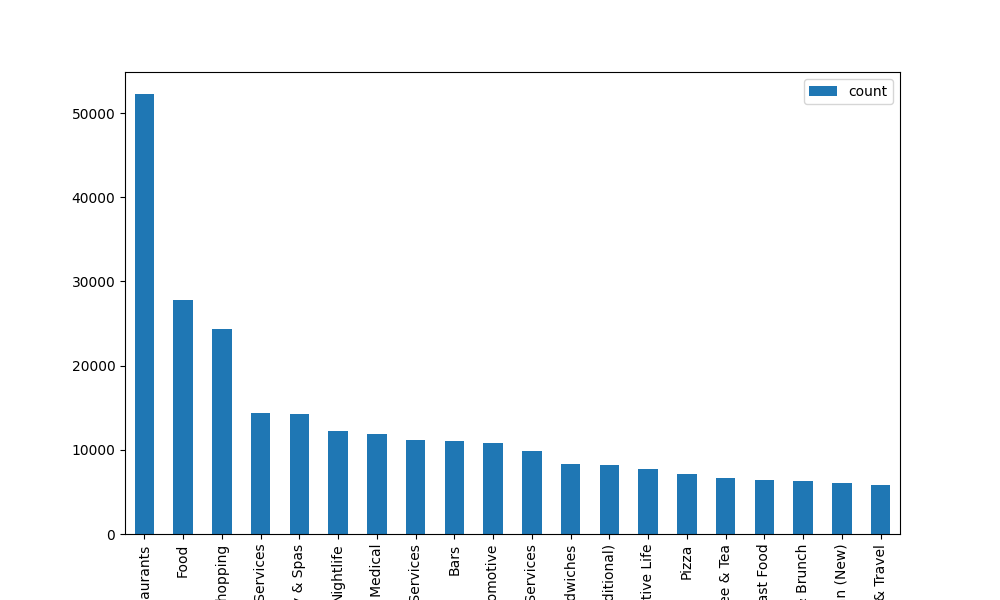

In [17]:
plt.figure(figsize=(10,6))
pdf[:20].plot(kind="bar", x="category", figsize=(10,6))
%matplot plt

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available. `s3://cis9760-yelpdataset/yelp-light/*review.json`

In [18]:
# I have already uploaded all of the Yelp JSON files at the beginning of this notebook. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [20]:
cleaned_review = review.select("business_id", "stars", "user_id") \
    .filter(review.business_id.isNotNull() & review.stars.isNotNull() & review.user_id.isNotNull()) \
    .withColumn("review_stars", col("stars"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
cleaned_review.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------
 business_id  | XQfwVwDr-v0ZS3_Cb... 
 stars        | 3.0                  
 user_id      | mh_-eMZ6K5RLWhZyI... 
 review_stars | 3.0                  
only showing top 1 row

In [22]:
cleaned_review.select("business_id", "stars").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-----+
|business_id           |stars|
+----------------------+-----+
|XQfwVwDr-v0ZS3_CbbE5Xw|3.0  |
|7ATYjTIgM3jUlt4UM3IypQ|5.0  |
|YjUWPpI6HXG530lwP-fb2A|3.0  |
|kxX2SOes4o-D3ZQBkiMRfA|5.0  |
|e4Vwtrqf-wpJfwesgvdgxQ|4.0  |
+----------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [23]:
new_review = cleaned_review.withColumn("stars", col("stars").cast("Integer")) \
    .filter(length(col("text")) > 0) \
    .groupBy("business_id") \
    .agg(mean("stars").alias("avg(stars)"))
new_review.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+------------------+
|business_id           |avg(stars)        |
+----------------------+------------------+
|zJErbOQMKX-MwHs_ulV7DA|2.9279279279279278|
|RZ-FNTXvqHKngyLGDM-c7w|2.8823529411764706|
|HSzSGdcNaU7heQe0NJibIg|3.3333333333333335|
|skW4boArIApRw9DXKXukkA|2.3947368421052633|
|I0053JmJ5DEFUWSJ8pikhA|2.3956043956043955|
+----------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [24]:
business_review = new_review.join(cleaned_business, "business_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
business_review.show(1,vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0------------------------------
 business_id    | --gJkxbsiSIwsQKbi... 
 avg(stars)     | 4.833333333333333    
 address        | 4545 W Kennedy Blvd  
 attributes     | [,,,,,,, True, Fa... 
 categories     | Skin Care, Hair S... 
 city           | Tampa                
 hours          | [8:0-20:0, 8:0-20... 
 is_open        | 1                    
 latitude       | 27.9451223           
 longitude      | -82.5210814          
 name           | Salon Lofts - Wes... 
 postal_code    | 33609                
 review_count   | 6                    
 stars          | 5.0                  
 state          | FL                   
 business_stars | 5.0                  
only showing top 1 row

Let's see a few of these:

In [26]:
business_review.select("name", "city", "state", "avg(stars)", "stars").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+------------+-----+------------------+-----+
|name                          |city        |state|avg(stars)        |stars|
+------------------------------+------------+-----+------------------+-----+
|Philadelphia Marriott Old City|Philadelphia|PA   |2.9279279279279278|3.0  |
|Gaetano's of West Berlin      |West Berlin |NJ   |2.8823529411764706|3.0  |
|Gillane's Bar & Grille        |Ardmore     |PA   |3.3333333333333335|3.0  |
|Champps Penn's Landing        |Philadelphia|PA   |2.3947368421052633|2.5  |
|Golden Corral Buffet & Grill  |Tucson      |AZ   |2.3956043956043955|2.5  |
+------------------------------+------------+-----+------------------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [27]:
business_review_skew = business_review \
    .withColumn("skew", (col("avg(stars)") - col("stars"))/col("stars"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
business_review_skew.select("name", "city", "state", "avg(stars)", "stars", "skew").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+------------+-----+------------------+-----+---------------------+
|name                          |city        |state|avg(stars)        |stars|skew                 |
+------------------------------+------------+-----+------------------+-----+---------------------+
|Gillane's Bar & Grille        |Ardmore     |PA   |3.3333333333333335|3.0  |0.11111111111111116  |
|Champps Penn's Landing        |Philadelphia|PA   |2.3947368421052633|2.5  |-0.04210526315789469 |
|Philadelphia Marriott Old City|Philadelphia|PA   |2.9279279279279278|3.0  |-0.024024024024024076|
|Golden Corral Buffet & Grill  |Tucson      |AZ   |2.3956043956043955|2.5  |-0.04175824175824179 |
|Swiss Watch Center            |Tampa       |FL   |3.357142857142857 |3.5  |-0.04081632653061223 |
+------------------------------+------------+-----+------------------+-----+---------------------+
only showing top 5 rows

And finally, graph it!

In [29]:
skew_pdf = business_review_skew.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

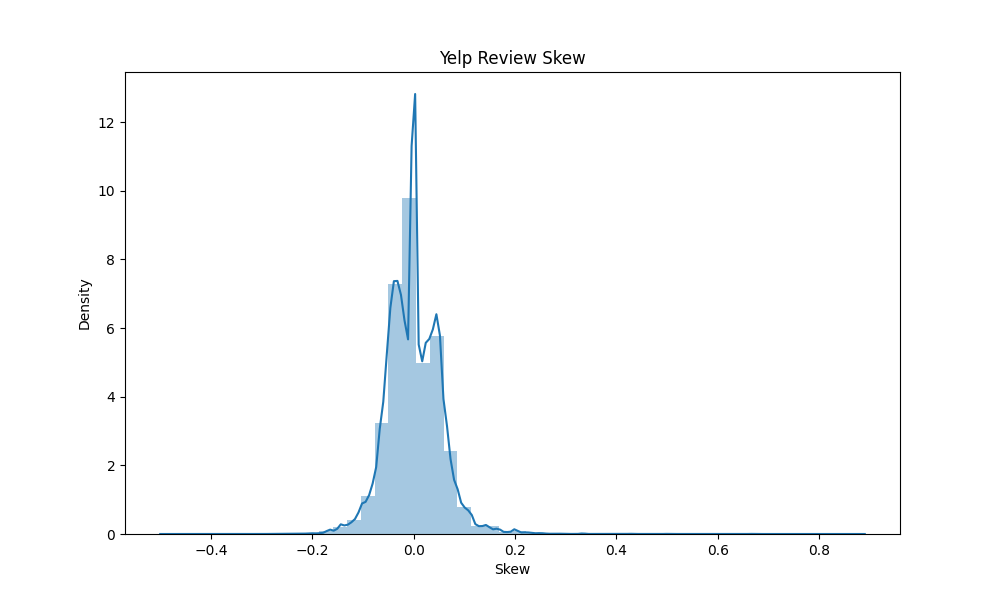

In [30]:
plt.figure(figsize=(10,6))
plt.title("Yelp Review Skew")
sns.distplot(skew_pdf['skew'], axlabel="Skew")
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

### IMPLICATIONS

Type your answer here: It appears that there are more reviews with negative skew than positive skew which indicates there are more dissatisfied reviewers who left written reviews. However, the skew is not massive so perhaps these reviewers were not extremely dissatisfied. This graph provides a little bit of insight on how reviewers felt. However, seeing as how these written reviews are text comments it might prove useful to do some sentiment analysis via NLP techniques. 

# Should the Elite be Trusted?

How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating? `s3://cis9760-yelpdataset/yelp-light/*user.json`

Feel free to use any and all methodologies at your disposal. 
You must render one visualization in your analysis and interpret your findings.

In [31]:
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [32]:
user.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------------
 average_stars      | 3.91                 
 compliment_cool    | 467                  
 compliment_cute    | 56                   
 compliment_funny   | 467                  
 compliment_hot     | 250                  
 compliment_list    | 18                   
 compliment_more    | 65                   
 compliment_note    | 232                  
 compliment_photos  | 180                  
 compliment_plain   | 844                  
 compliment_profile | 55                   
 compliment_writer  | 239                  
 cool               | 5994                 
 elite              | 2007                 
 fans               | 267                  
 friends            | NSCy54eWehBJyZdG2... 
 funny              | 1259                 
 name               | Walker               
 review_count       | 585                  
 useful             | 7217                 
 user_id            | qVc8ODYU5SZjKXVBg... 
 yelping_since      | 2007-01-25

In [33]:
print(f"Number of columns in the User table: {len(user.columns)}", f"Number of rows in the Business table: {user.count()}", sep='\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in the User table: 22
Number of rows in the Business table: 1987897

In [34]:
elite_users = user.filter(length(col("elite")) > 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
print(f"Number of columns in the User table: {len(elite_users.columns)}", f"Number of rows in the Business table: {elite_users.count()}", sep='\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in the User table: 22
Number of rows in the Business table: 91198

In [36]:
print(f"As we can see {round((elite_users.count()/user.count())*100,2)}% of the users are elite users.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As we can see 4.59% of the users are elite users.

In [37]:
business_review2 = cleaned_business.join(cleaned_review, "business_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
business_review2.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+-----+-----------------------------------------------------------------------+-------+----------+-----------+--------------------------+-----------+------------+-----+-----+--------------+-----+----------------------+------------+
|business_id           |address            |attributes                                                                                                                                                     |categories                                                  |city |hours                                                                  |is_open|latitude  |longitude  |name                      |postal_code|review_count|stars|state|business_stars|stars|user_id               |review_stars|
+-------

In [39]:
elite_users.agg({'useful': 'max'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|max(useful)|
+-----------+
|     206296|
+-----------+

In [40]:
elite_users.agg({'useful': 'min'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|min(useful)|
+-----------+
|          0|
+-----------+

In [41]:
elite_users.agg({'useful': 'avg'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|      avg(useful)|
+-----------------+
|650.9082436018334|
+-----------------+

In [42]:
business_review_elite_users = business_review2.join(elite_users, "user_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
business_review_elite_users.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+--------------------+--------------------+-----------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------------+-----+------------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-------------------+----+--------------------+-----+----+------------+------+-------------------+
|             user_id|         business_id|        address|          attributes|          categories|       city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|business_stars|stars|review_stars|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_p

In [44]:
print(business_review_elite_users.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['user_id', 'business_id', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state', 'business_stars', 'stars', 'review_stars', 'average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful', 'yelping_since']

In [45]:
business_review_elite_diff = business_review_elite_users \
    .withColumn("review_diff", (col("business_stars") - col("review_stars")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
business_review_elite_diff.select("business_stars", "review_stars", "review_diff").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------+-----------+
|business_stars|review_stars|review_diff|
+--------------+------------+-----------+
|           4.5|         4.0|        0.5|
|           4.0|         5.0|       -1.0|
|           4.0|         5.0|       -1.0|
|           2.5|         3.0|       -0.5|
|           4.5|         5.0|       -0.5|
+--------------+------------+-----------+
only showing top 5 rows

In [47]:
diff_pdf = business_review_elite_diff.select("review_diff").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

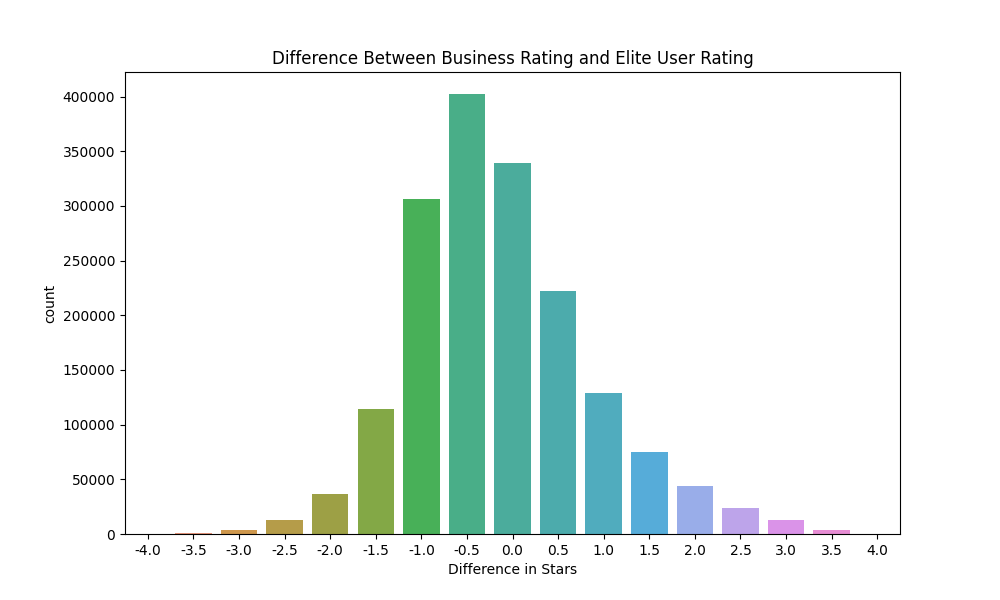

In [48]:
plt.figure(figsize=(10,6))
plt.title("Difference Between Business Rating and Elite User Rating")
sns.countplot(diff_pdf['review_diff']).set_xlabel("Difference in Stars")
%matplot plt

In [49]:
business_review_elite_users_filtered = business_review_elite_users \
    .filter(col("useful") > 650)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
business_review_elite_diff_filtered = business_review_elite_users_filtered \
    .withColumn("review_diff", (col("business_stars") - col("review_stars")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
business_review_elite_diff_filtered.select("business_stars", "review_stars", "review_diff").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------+-----------+
|business_stars|review_stars|review_diff|
+--------------+------------+-----------+
|           4.0|         5.0|       -1.0|
|           4.5|         4.0|        0.5|
|           2.0|         4.0|       -2.0|
|           4.0|         5.0|       -1.0|
|           4.0|         5.0|       -1.0|
+--------------+------------+-----------+
only showing top 5 rows

In [52]:
diff_pdf_filtered = business_review_elite_diff_filtered.select("review_diff").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

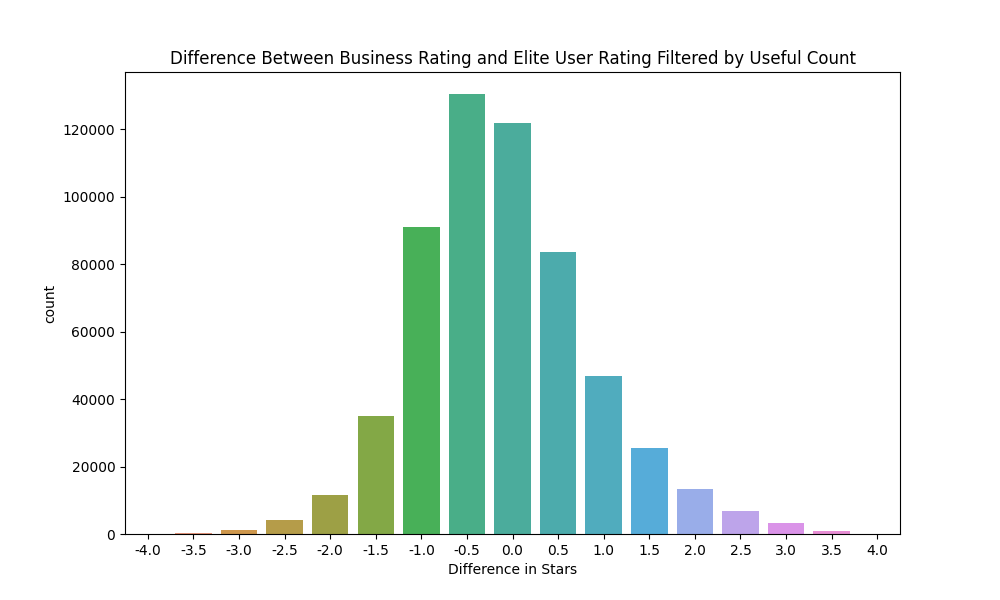

In [53]:
plt.figure(figsize=(10,6))
plt.title("Difference Between Business Rating and Elite User Rating Filtered by Useful Count")
sns.countplot(diff_pdf_filtered['review_diff']).set_xlabel("Difference in Stars")
%matplot plt

To determine whether the reviews of elite users could be trusted I first took the difference between the business reviews and the reviews left by the elite users and then took a count of these various differences. I then filtered the reviews with those who had a useful count greater than 650 since that was the average number of useful counts. I once again took the difference and plotted the count. As we can see from the charts that the distribution of the difference in stars appears to be the same where most of the differences are between -1.0 and 0.5. The reason I filtered by useful count is because those are reviews that other Yelp users found helpful and so I felt that should give us a better idea of whether or not elite users should be trusted. Based on all of this, I would claim that elite users that have a large number of useful reviews (> 650) can be trusted. 